In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import os
root_path = 'gdrive/My Drive/EACL/'
os.chdir(root_path)

Mounted at /content/gdrive


In [2]:
!pip install sentencepiece==0.1.94
!pip install transformers==4.0.1
!pip install demoji
!pip install tweet-preprocessor
!pip install git+git://github.com/irshadbhat/indic-trans.git
# !pip install transformers[sentencepiece]

     |████████████████████████████████| 1.4MB 8.0MB/s 
     |████████████████████████████████| 2.9MB 28.4MB/s 
     |████████████████████████████████| 890kB 44.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=00ce9e68f4d3d2225e149451a7bfea27d2c4aec968fe5decd65c240f96c985ac
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Cloning git://github.com/irshadbhat/indic-trans.git to /tmp/pip-req-build-8xrn95zk
  Running command git clone -q git://github.com/irshadbhat/indic-trans.git /tmp/pip-req-build-8xrn95zk
  Using cached https://files.pythonhosted.org/packages/fb/48/69046506f6ac61c1eaa9a0d42d22d54673b69e176d30ca98e3f61513e980/pbr-5.5.1-py2.py3-none-any.whl
  Created wheel for indictrans: filename=indictrans-1.2.3-cp36-cp36m-linux_x86_64.whl size=337563819 sha256=621179be3bc8532cd6f4ad066530913acd567497af5f58ccb4cac271223b264d
  Stored in directory

In [3]:
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch.nn as nn
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm
import demoji 
import random
demoji.download_codes() 
import preprocessor as p
from indictrans import Transliterator
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42
model_path = 'ai4bharat/indic-bert'
model_path = 'xlm-roberta-base'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

... OK (Got response in 0.16 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [5]:
class Dataset_OLID():
    def __init__(self, train_data, batch_size = 32):
        self.train_data = train_data
        self.batch_size = batch_size

        self.label_dict = {'Not_offensive': 0,
                            'Offensive_Targeted_Insult_Group': 3,
                            'Offensive_Targeted_Insult_Individual': 2,
                            'Offensive_Targeted_Insult_Other': 4,
                            'Offensive_Untargetede': 1}
                                    
        self.count_dic = {}
        self.train_dataset = self.process_data(self.train_data)

    def tokenize(self, sentences, padding = True, max_len = 256):
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': (input_ids), 'attention_masks': (attention_masks)}
    
    def process_data(self, data):
        sentences, labels = [], []
        print(len(data))
        for id,line in enumerate(data):
            if id==0: continue
            sentence = line.strip().split('\t')
            label = sentence[2:]

            if label[0] == 'NOT': labels.append(0)
            elif label[1] == 'UNT': labels.append(1)
            elif label[2] == 'IND': labels.append(2)
            elif label[2] == 'GRP': labels.append(3)
            else: labels.append(4)

            sentence = sentence[1].replace('#','').lower()
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)
        return TensorDataset(inputs['input_ids'], inputs['attention_masks'], torch.Tensor(labels))
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [6]:
with open('OLIDv1.0/olid-training-v1.0.tsv', 'r') as f:
    train_data = f.readlines()
olid_data = Dataset_OLID(train_data)

13241


In [7]:
tr1 = Transliterator(source='tam', target='eng', build_lookup=True)
tr2 = Transliterator(source='mal', target='eng', build_lookup=True)
tr3 = Transliterator(source='kan', target='eng', build_lookup=True)

In [8]:
class Dataset():
    def __init__(self, train_data, val_data, batch_size = 32):
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size

        self.label_dict = {'Not_offensive': 0,
                            'Offensive_Targeted_Insult_Group': 3,
                            'Offensive_Targeted_Insult_Individual': 2,
                            'Offensive_Targeted_Insult_Other': 4,
                            'Offensive_Untargetede': 1}
        self.count_dic = {}
        self.train_dataset = self.process_data(self.train_data)
        self.val_dataset = self.process_data(self.val_data)

        # self.train_dataloader = self.get_dataloader(self.train_inputs, self.train_labels)
        # self.val_dataloader = self.get_dataloader(self.val_inputs, self. val_labels, train = False)

    def tokenize(self, sentences, padding = True, max_len = 256):
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data):
        tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
        sentences, labels = [], []
        print(len(data))
        for line in data:
            sentence = line.strip().split('\t')
            label = sentence.pop()
            if label not in self.label_dict: continue
            sentence = ((' '+tokenizer.sep_token+' ').join(sentence)).replace('#','').lower()
            sentence = tr3.transform(tr2.transform(tr1.transform(sentence)))
            # sentence = p.clean(' '.join(sentence)).replace('#','')
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            # if label =='Not_offensive': labels.append(0)
            # else: 
            labels.append(self.label_dict[label])
            self.count_dic[labels[-1]] = self.count_dic.get(labels[-1], 0) + 1
        inputs = self.tokenize(sentences)

        return TensorDataset(inputs['input_ids'], inputs['attention_masks'], torch.Tensor(labels))
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [9]:
with open('Dataset/kannada_offensive_train.csv', 'r') as f:
    train_data = f.readlines()
with open('Dataset/kannada_offensive_dev.csv', 'r') as f:
    val_data = f.readlines()
kan_data = Dataset(train_data, val_data)

with open('Dataset/mal_full_offensive_train.csv', 'r') as f:
    train_data = f.readlines()
with open('./Dataset/mal_full_offensive_dev.csv', 'r') as f:
    val_data = f.readlines()
mal_data = Dataset(train_data, val_data)

with open('Dataset/tamil_offensive_full_train.csv', 'r') as f:
    train_data = f.readlines()
print(1)
with open('Dataset/tamil_offensive_full_dev.csv', 'r') as f:
    val_data = f.readlines()
tam_data = Dataset(train_data, val_data)

6217
777
16010
1999
1
35139
4388


In [10]:
# Save and Load Functions
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

In [11]:
class Transform(torch.nn.Module):
    def __init__(self, D_in):
        super(Transform, self).__init__()
        self.embeddings = AutoModel.from_pretrained(model_path)
        self.dropout = nn.Dropout(0.3)
        self.final = nn.Linear(D_in*2, 5, bias = True)

    def forward(self, input_ids, mask):
        outputs = self.embeddings(input_ids, mask)
        out = outputs.last_hidden_state
        mean_pooling = torch.mean(out, 1)
        max_pooling, _ = torch.max(out, 1)

        embed = torch.cat((mean_pooling, max_pooling), 1)

        # embed = outputs.pooler_output
        # print(embed.shape)
        y_pred = self.final(self.dropout(embed))
        return y_pred

In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
 
def evaluate(test_dataloader, model):
    model.eval()
    y_preds, y_test = np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            ypred = model(b_input_ids, b_input_mask)
        ypred = ypred.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))

    weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath, weights = None, learning_rate = 2e-5, epochs = 4, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    if weights == None:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.CrossEntropyLoss(weight=weights)
    for epoch_i in tqdm(range(current_epoch, epochs)):
        model.train()
        for step, batch in enumerate(training_dataloader):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
            
            outputs = model(b_input_ids, b_input_mask)
            loss = criterion(outputs, b_labels)
 
            if step%print_every == 0:
                print(loss.item())
 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model)
        print("  Weighted F1: {0:.2f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            save_metrics(filepath, epoch_i, model.embeddings, optimizer, weighted_f1)

In [13]:
train_dataset = ConcatDataset([olid_data.train_dataset, kan_data.train_dataset, mal_data.train_dataset, tam_data.train_dataset])
# train_dataset = ConcatDataset([mal_data.train_dataset, tam_data.train_dataset])
val_dataset = kan_data.val_dataset

In [14]:
count_dic = {}
for data in train_dataset:
    label = int(data[2])
    count_dic[label] = count_dic.get(label, 0)+1
weights = torch.Tensor([1+np.log(len(train_dataset)/count_dic[i]) for i in range(5)]).to(device)

In [15]:
weights

tensor([1.2443, 3.8512, 3.4945, 3.7839, 5.2232], device='cuda:0')

In [16]:
len(train_dataset)

66343

In [17]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=64)

In [18]:
model = Transform(768).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5, eps = 1e-8)
# load_metrics('olid_kannada_mbert.pt', model, optimizer)

In [19]:
train(train_dataloader, val_dataloader, model, 'olid_xlmr_base_embed_new.pt', epochs=4)

Model loaded from <== olid_xlmr_base_embed_new.pt


  0%|          | 0/4 [00:00<?, ?it/s]

1.751341462135315
1.0627092123031616
0.6708449125289917
0.6593468189239502
1.1215810775756836
0.573792040348053
0.8200603127479553
0.6632243990898132
0.8496990203857422
0.5638996958732605
0.7563316822052002
0.6735098958015442
0.5858340263366699
0.8358088135719299
0.656430184841156
0.5074678659439087
0.6360606551170349
0.6611775755882263
0.601325273513794
0.6687053442001343
0.6183404922485352
0.8178309202194214
0.7203651666641235
1.0944753885269165
0.8790910243988037
1.0528042316436768
0.4580274522304535
0.7338598370552063
0.7965366244316101
1.028313398361206
0.7035080790519714
0.6004306674003601
0.7015998363494873
0.8062409162521362
0.6736184358596802
0.6536933779716492
0.5583807229995728
0.7573779821395874
0.7637655138969421
0.31203293800354004
0.51874840259552
0.4063454270362854
0.4061221182346344
0.40398651361465454
0.8784817457199097
0.36521217226982117
0.4844135642051697
0.653873085975647
0.6518186926841736
0.535275399684906
0.5025563836097717
0.5851871371269226
0.6875863671302795

 25%|██▌       | 1/4 [59:35<2:58:46, 3575.42s/it]

0.561593234539032
0.7255741357803345
0.35530972480773926
0.7918081283569336
0.36701110005378723
0.6283992528915405
0.6715635657310486
0.47535496950149536
0.8931559324264526
0.47893843054771423
0.8083702921867371
0.5329588055610657
0.7327538728713989
0.8312484622001648
0.8537818789482117
0.5378156304359436
0.5815435647964478
0.7757184505462646
0.4007697105407715
0.7295933365821838
0.5762597918510437
1.068435549736023
0.4513290226459503
0.7495718598365784
0.7462981343269348
0.6152436137199402
0.8719783425331116
0.7574350833892822
0.5910520553588867
0.6300039887428284
0.4892324209213257
0.3954327404499054
0.41132912039756775
0.7007125020027161
0.3764229714870453
0.6505163311958313
0.5241413712501526
0.5590556263923645
0.6519147753715515
0.4854189455509186
0.5623990893363953
0.5132643580436707
0.47539228200912476
0.3985813856124878
0.6999915838241577
0.5434626936912537
0.5843637585639954
1.034172773361206
0.640710711479187
0.47232526540756226
1.021987795829773
0.6681153178215027
0.62578004

 50%|█████     | 2/4 [1:59:41<1:59:28, 3584.48s/it]

0.4341869354248047
0.4278391897678375
0.528828501701355
0.3996262550354004
0.2227293998003006
0.695406973361969
0.7679163217544556
0.5746092796325684
0.23355776071548462
0.567965030670166
0.458365797996521
0.7374356389045715
0.5785661935806274
0.6171560883522034
0.366499662399292
0.4620417356491089
0.5094531774520874
0.5621411800384521
0.47842833399772644
0.7184973955154419
0.439508855342865
0.2518799304962158
0.5755337476730347
0.8239831924438477
0.6883689165115356
0.7133340239524841
0.37729114294052124
0.6057672500610352
0.31802234053611755
0.38093698024749756
0.4259544312953949
0.9656674265861511
0.24595104157924652
0.21630914509296417
0.38321587443351746
0.2560148537158966
0.514478862285614
0.43949854373931885
0.40945965051651
0.7302869558334351
0.20335228741168976
0.3857786953449249
0.42088082432746887
0.6069715023040771
0.5869030356407166
0.8445772528648376
0.32092779874801636
0.4412649869918823
0.39382240176200867
0.49017322063446045
0.47507038712501526
0.7489639520645142
0.5944

 75%|███████▌  | 3/4 [3:00:38<1:00:06, 3606.52s/it]

0.29830202460289
0.2564001679420471
0.3522346019744873
1.005892276763916
0.37040919065475464
0.3117293417453766
0.6084314584732056
0.5367423892021179
0.2104782909154892
0.6337138414382935
0.2513166666030884
0.4864550828933716
0.41542288661003113
0.3323345184326172
0.6042909026145935
0.4350341558456421
0.42203670740127563
0.639118492603302
0.6386337280273438
0.5496322512626648
0.6725476980209351

0.5542972683906555
0.41967326402664185
0.28705286979675293
0.6327831745147705
0.44221147894859314
0.5313938856124878
0.4238523840904236
0.4970928132534027
0.4683799743652344
0.3404148519039154
0.6094008088111877
0.32506653666496277
0.49784135818481445
0.5328210592269897
0.3799856901168823
0.382811576128006
0.1932453066110611
0.41771772503852844
0.5844298601150513
0.3713071048259735
0.6353477239608765
0.2178327888250351
0.23724602162837982
0.6300913691520691
0.4234616458415985
0.21955302357673645
0.30516934394836426

0.1866985708475113
0.7568769454956055
0.6716615557670593
0.3699956238269806
0.5

100%|██████████| 4/4 [4:01:28<00:00, 3622.12s/it]


In [ ]:
_, ypred, ytest = evaluate(data.val_dataloader, model)
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, ypred)

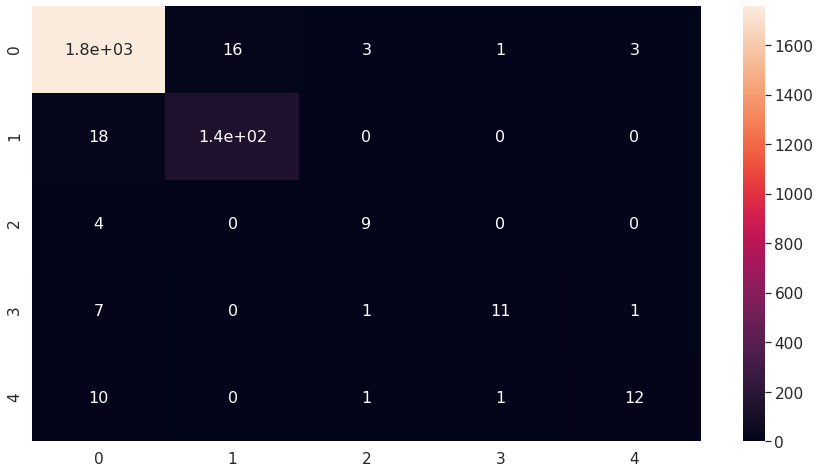

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
train(data.train_dataloader, data.val_dataloader, model, 'tamil_mal.pt')